In [1]:
import tensorflow as tf
import numpy as np

In [2]:
#method for creating labels and features
def windowed_datset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size=batch_size).prefetch(1)
    return dataset

#Method for creating trend
def trend(time, slope=0):
    return slope * time

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [3]:
#Create a time series
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline =10
amplitude = 40
slope = 0.05
noise_level = 5
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [4]:
#Create training and validation datasets
split_time =1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
#Create features and labels
window_size= 20
batch_size= 32
shuffle_buffer=10

dataset = windowed_datset(series,window_size, batch_size, shuffle_buffer)
layers_01 = tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu")
layers_02 = tf.keras.layers.Dense(10,  activation="relu")
layers_03 = tf.keras.layers.Dense(1, activation="relu")
model = tf.keras.models.Sequential(layers=[layers_01, layers_02, layers_03])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0 )

In [6]:
#Create a forecasted series for plotting the predited values.
forecast =[]
for value in range(len(series) - window_size):
    forecast.append(model.predict(series[value: value + window_size][np.newaxis]))
# We got the full prediction 0 to n but we only want to see the values in the validation part.
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

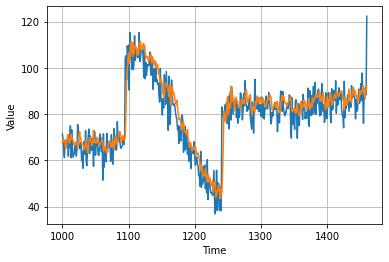

In [7]:
#methow for plotting
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plot_series(time_valid,x_valid)
plot_series(time_valid, results)

In [8]:
#Mean Absolute error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2805314

## Hypertuning the learning rate - find the optimized larning rate using call back

In [9]:
lr_scehduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_scehduler], verbose =1)

Epoch 1/100
46/46 [==============================] - 0s 6ms/step - loss: 47.6685
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 46.4137
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 45.6950

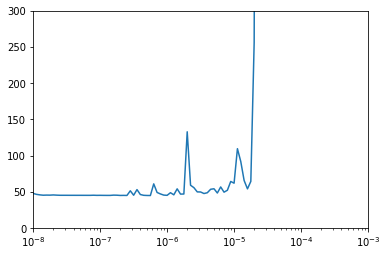

In [10]:
#Plot the learning rate scheduler
lrs = 1e-8 * (10 **(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0,300])
plt.show()

In [11]:
window_size=30
dataset = windowed_datset(series,window_size, batch_size, shuffle_buffer)
layers_01 = tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu")
layers_02 = tf.keras.layers.Dense(10,  activation="relu")
layers_03 = tf.keras.layers.Dense(1, activation="relu")
model = tf.keras.models.Sequential(layers=[layers_01, layers_02, layers_03])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9))
history =model.fit(dataset, epochs=500, verbose=1 )


Epoch 1/500
45/45 [==============================] - 0s 9ms/step - loss: 139.0149
Epoch 2/500
45/45 [==============================] - 0s 7ms/step - loss: 160.6050
Epoch 3/500
45/45 [=============================

KeyError: 'acc'

[55.67574691772461, 52.97249984741211, 52.48639678955078, 51.224639892578125, 54.722381591796875, 51.362693786621094, 51.324398040771484, 49.8192253112793, 51.31790542602539, 50.78194808959961, 53.23960876464844, 50.66534423828125, 48.493656158447266, 49.95558547973633, 48.721893310546875, 49.36720275878906, 48.88031768798828, 51.50554275512695, 48.84965133666992, 47.00052261352539, 47.40156936645508, 48.36418914794922, 49.694374084472656, 47.24706268310547, 46.2877311706543, 46.310882568359375, 46.48417663574219, 46.61542892456055, 47.745906829833984, 49.865352630615234, 50.72010803222656, 47.304012298583984, 47.76610565185547, 47.23912048339844, 47.82949447631836, 48.07632827758789, 46.41236877441406, 46.61683654785156, 46.414451599121094, 49.451229095458984, 47.226078033447266, 46.13548278808594, 46.04715347290039, 45.538856506347656, 46.03203582763672, 46.845420837402344, 46.77098083496094, 45.614418029785156, 46.62529373168945, 45.30730438232422, 47.83028793334961, 48.757381439208

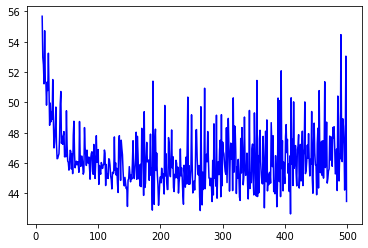

In [13]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()



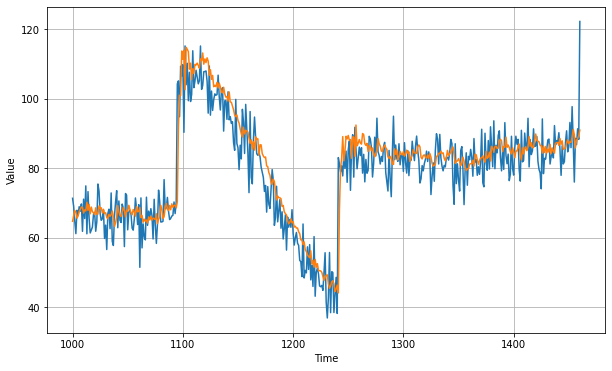

In [14]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


4.98675